In [119]:
import torch
from PIL import Image
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import timm
import argparse
import yaml
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils

import rasterio
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms.functional as F
#--- dataset class 
class Map_Dataset(torch.utils.data.Dataset):      
    def __init__(self, list_IDs,transform,train_path): 
        self.list_IDs = list_IDs
        self.transform = transform
        self.train_path = train_path
    def __len__(self):
        return len(self.list_IDs)
    
    def ratio_pad(self,img_da):
        # PIL_image = Image.fromarray(bb)

        #--
        max_value = 376
        width_, height_ = img_da.shape[0],img_da.shape[1]
        print(width_,height_)
        #--

        if width_ < max_value:
            width_pad = max_value - width_
            if width_pad//2 == max_value:
                width_pad = width_pad//2
            elif width_pad//2 > max_value:
                width_pad = width_pad//2 - 2
            elif width_pad//2 < max_value:
                width_pad = width_pad//2 
        else:
            width_pad = 0 

        if height_ < max_value:
            height_pad = max_value - height_
            
            if height_pad//2 == max_value:
                height_pad = height_pad//2
            elif height_pad//2 > max_value:
                height_pad = height_pad//2 - 2
            elif height_pad//2 < max_value:
                height_pad = height_pad//2
        else:
            height_pad = 0
        #--
        img_da = Image.fromarray(img_da)

        img_da = F.pad(img=img_da,padding=(height_pad,width_pad), padding_mode="constant", fill=0)
        
        return img_da
    
    def __getitem__(self, index): 
        ID = self.list_IDs[index] 
        X1 = Image.open(self.train_path + ID + '/street.jpg').convert('RGB')
        #X1 = cv2.resize(X1, (256, 256))
        #X1 = np.asarray(X1)
        #X1 = np.transpose(X1,[1, 2, 0])
        if self.transform:
            X1 = self.transform(X1)
            X1 = self.ratio_pad(X1)
        #X1 = cv2.resize(X1, (256, 256)) 
        
        X2 = Image.open(self.train_path + ID + '/orthophoto.tif')  
        if self.transform:
            X2 = self.transform(X2)
        #X2 = cv2.resize(X2, (256, 256)) 
        
        
        X3 = rasterio.open(self.train_path + ID + '/s2_l2a.tif').read() 
        X3 = np.transpose(X3, [1, 2, 0]) 
        #X3 = self.transform(X3)
        
        y = int(open(self.train_path + ID + '/label.txt', "r").read())
        return X1,X2,X3, y 
    
#---

In [29]:
# #--- argparser
# parser = argparse.ArgumentParser()
# parser.add_argument('--cfg', type=str, default='/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/configs/finetune.yaml')
# args = parser.parse_args()
# cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))


In [30]:
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

In [31]:
#--- data split 
names_data = os.listdir(train_path)
# if cfg.SAMPLE:
#     parse_idx = int(len(names_data) * 0.01)
#     names_data = names_data[:parse_idx]
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

624
(256, 368, 3)


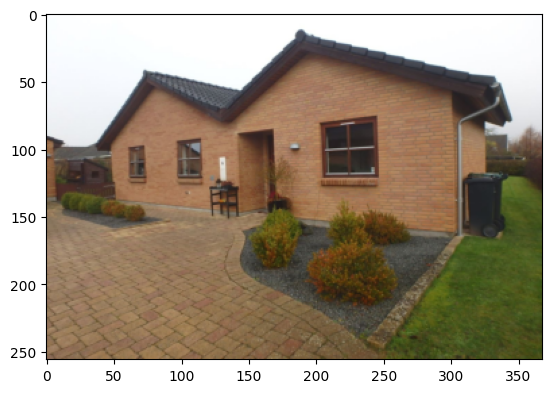

In [240]:
# width : height = 2 : 3 = 1000 : 1500
# 256 : 375

data_transform = torchvision.transforms.Resize(
    size=256, max_size= 376
)


train_set = Map_Dataset(names_train, data_transform, train_path) 
test_set = Map_Dataset(names_train, False, train_path) 

import random
qq = random.randint(0,999)
#qq = 855
print(qq)
aa = train_set.__getitem__(qq)[0]
bb = test_set.__getitem__(qq)[0]
aa = np.asarray(aa)
bb = np.asarray(bb)

print(aa.shape)
#print(bb.shape)
plt.imshow(aa)

In [241]:
aa.shape

(256, 368, 3)

In [242]:
# PIL_image = Image.fromarray(bb)

#--
max_value = 376
width_, height_ = aa.shape[0],aa.shape[1]
print(width_,height_)
#--

if width_ < max_value:
    width_pad = max_value - width_
    if width_pad//2 == max_value:
        width_pad = width_pad//2
    elif width_pad//2 > max_value:
        width_pad = width_pad//2 - 2
    elif width_pad//2 < max_value:
        width_pad = width_pad//2 
else:
    width_pad = 0 

if height_ < max_value:
    height_pad = max_value - height_
    
    if height_pad//2 == max_value:
        height_pad = height_pad//2
    elif height_pad//2 > max_value:
        height_pad = height_pad//2 - 2
    elif height_pad//2 < max_value:
        height_pad = height_pad//2
else:
    height_pad = 0
#--
aa = Image.fromarray(aa)

aa_pad = F.pad(img=aa,padding=(height_pad,width_pad), padding_mode="constant", fill=0)

256 368


In [243]:
aa_pad
ww = np.array(aa_pad)
print(ww.shape)

(376, 376, 3)


In [188]:
ww = np.array(aa_pad)

In [189]:
ww.shape

(376, 376, 3)

In [71]:
#--- model 
model = timm.create_model(
"vit_huge_patch14_clip_336.laion2b_ft_in12k_in1k",
pretrained=True,
num_classes=7 ) 

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_huge_patch14_clip_336.laion2b_ft_in12k_in1k)
INFO:timm.models._hub:[timm/vit_huge_patch14_clip_336.laion2b_ft_in12k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [132]:
#--- data config and transform
data_config = timm.data.resolve_model_data_config(model)
data_config

{'input_size': (3, 336, 336),
 'interpolation': 'bicubic',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'crop_pct': 1.0,
 'crop_mode': 'squash'}

In [133]:
data_config['max_size'] = 256
data_config['interpolation'] = 'bilinear'

In [136]:
torchvision.transforms.

{'input_size': (3, 336, 336),
 'interpolation': 'bilinear',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'crop_pct': 1.0,
 'crop_mode': 'squash',
 'max_size': 256}

In [138]:
timm.data.transforms.ResizeKeepRatio(size=512,longest=512)

ResizeKeepRatio(size=(512, 512), interpolation=bilinear), longest=512.000)

In [135]:
#del data_config['input_size']  
data_transform = timm.data.create_transform(**data_config, is_training=False)

# data_resize = timm.data.transforms.ResizeKeepRatio(size=(3,256,512), interpolation='bilinear' )
# data_normalzie = timm.data.transforms

TypeError: create_transform() got an unexpected keyword argument 'max_size'

In [131]:
data_transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0.4815, 0.4578, 0.4082]), std=tensor([0.2686, 0.2613, 0.2758]))
)

In [107]:
train_set = Map_Dataset(names_train,data_transform,train_path) 
trainloader = DataLoader(train_set, 32, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)

In [114]:
from tqdm import tqdm
tmp_ = []

for name in tqdm(names_data):
    full_name = os.path.join(train_path, name, 'street.jpg')
    X1 = Image.open(full_name).convert('RGB')
    X1 = np.asarray(X1)
    tmp_.append(X1.shape)
    #print(X1.shape)

100%|██████████| 30849/30849 [02:56<00:00, 174.69it/s]


In [116]:
tmp_

[(523, 1024, 3),
 (1024, 512, 3),
 (1024, 630, 3),
 (1000, 1440, 3),
 (1000, 1440, 3),
 (1024, 512, 3),
 (1000, 1440, 3),
 (580, 1024, 3),
 (1024, 512, 3),
 (1024, 680, 3),
 (804, 1024, 3),
 (1024, 512, 3),
 (532, 766, 3),
 (1024, 846, 3),
 (1024, 512, 3),
 (480, 640, 3),
 (670, 1024, 3),
 (1024, 968, 3),
 (1024, 741, 3),
 (1024, 920, 3),
 (1000, 1440, 3),
 (480, 640, 3),
 (1000, 1440, 3),
 (865, 1024, 3),
 (1024, 512, 3),
 (1024, 512, 3),
 (1024, 512, 3),
 (1024, 512, 3),
 (768, 1024, 3),
 (621, 1024, 3),
 (1000, 1440, 3),
 (1000, 1440, 3),
 (1024, 589, 3),
 (1024, 896, 3),
 (512, 1024, 3),
 (684, 1024, 3),
 (1024, 533, 3),
 (1024, 512, 3),
 (1024, 512, 3),
 (1024, 827, 3),
 (1024, 607, 3),
 (711, 1024, 3),
 (512, 1024, 3),
 (614, 1024, 3),
 (1000, 1440, 3),
 (1024, 689, 3),
 (512, 1024, 3),
 (1000, 1440, 3),
 (1024, 512, 3),
 (512, 1024, 3),
 (512, 1024, 3),
 (512, 1024, 3),
 (1024, 512, 3),
 (1024, 621, 3),
 (772, 1024, 3),
 (1024, 512, 3),
 (1024, 606, 3),
 (1024, 692, 3),
 (1024, 

width mean :  892.7150636973646


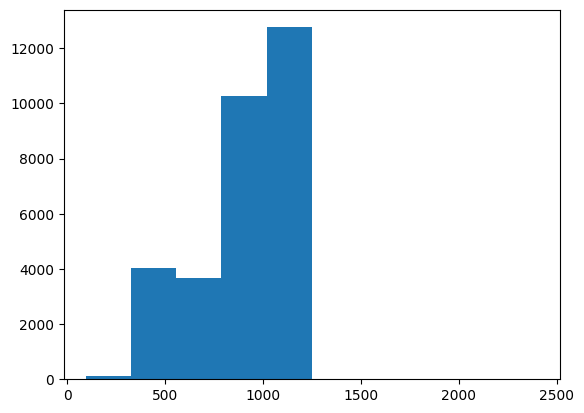

In [123]:
width_s = [t[0] for t in tmp_]
height_s = [t[1] for t in tmp_]

plt.hist(width_s)
print("width mean : " , np.mean(width_s))

height mean :  949.8062497974003


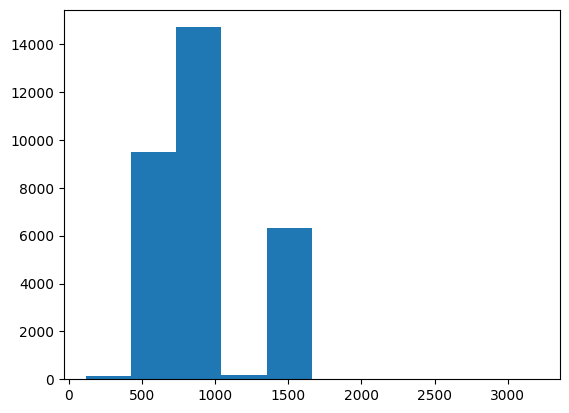

In [122]:
plt.hist(height_s)
print("height mean : " , np.mean(height_s))

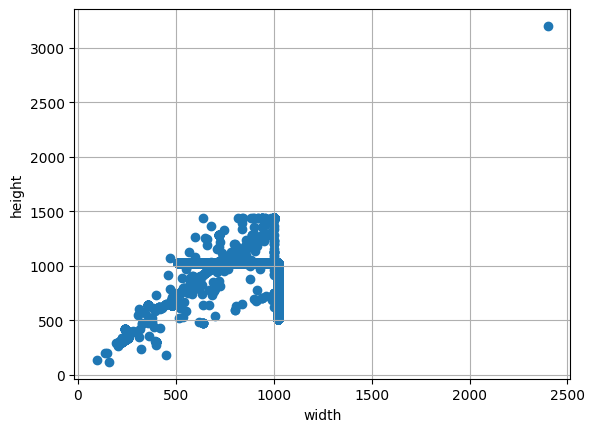

<Figure size 1200x1200 with 0 Axes>

In [126]:
plt.scatter(width_s, height_s)
plt.xlabel("width")
plt.ylabel("height")
plt.grid()
plt.figure(figsize=(12,12))
plt.show()

<class 'torch.Tensor'>
total :  30849
idx :  25003
label :  5
1993-2006


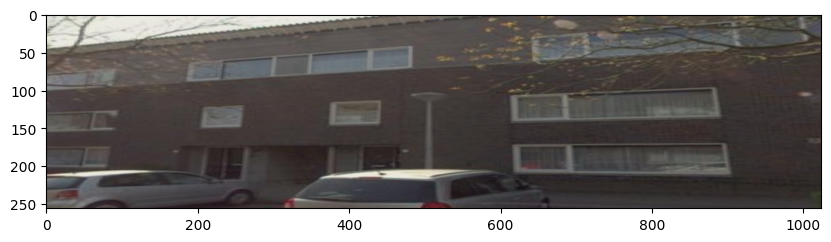

In [52]:
import random
idx = random.randint(0,len(names_data))

t_img = train_set.__getitem__(idx)[0]

print(type(t_img))
if str(type(t_img)).__contains__("torch"):
    RS_utils.torch_display(t_img, False,True)
elif str(type(t_img)).__contains__("numpy"):
    print(t_img.shape)
    #plt.imshow(t_img)
    

     
label = train_set.__getitem__(idx)[-1]
print("total : ", len(names_data))
print("idx : ",idx)
print("label : ",label)

label_map ={
    "x<1930" : 0,
    "1930-1945" : 1,
    "1946-1960" : 2,
    "1961-1976" : 3,
    "1977-1992" : 4, 
    "1993-2006" : 5,
    "x>2006" : 6
    }

for i, v in label_map.items():
    if label == v:
        print(i)